# Copula Optimal Transport Distance Metrics

This notebook explores the paper Optimal Copula Transport for Clustering Multivariate Time Series (Marti et. al., 2015), with the assistance of the author's blog. The dependence measure is adapted to form a "distance" measure, and is contrasted with the Wasserstein distance and what the dependence measure should be most similar to, Pearson's $r$. 

It should be emphasized that the dependence measure is not a metric. Neither is it one when it's subtracted from 1. 

The following links are very helpful.

https://gmarti.gitlab.io/qfin/2020/06/25/copula-optimal-transport-dependence.html
https://gmarti.gitlab.io/qfin/2020/07/29/wasserstein-barycenter-margins-stocks-sampling.html


In [205]:
#bread and butter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#exotic clustering algorithm, TDA
from tomaster import tomato
import kmapper
import gudhi
from gudhi.clustering.tomato import Tomato

#machine learning library
import sklearn

#machine learning library for time series
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

#statistics
import scipy
from scipy.stats import rankdata, norm
import ot

#backtester
import bt

#misc
%matplotlib inline
plt.style.use('matplotlibrc')

In [63]:
tech = ['aapl', 'msft', 'goog', 'amzn', 'fb']
tech_prices = bt.get(tech, start='2015-01-01')
tech_returns = tech_prices.pct_change(1).dropna()

In [165]:
nb_obs = len(tech_returns)
nb_obs

1572

## Optimal Copula Transport for Estimating Dependence Between Random Variables

Our time series here are univariate, so in the TDC measure the min in the denominator reduces to the minimum between the distance between the empirical and perfect dependence distributions and the empirical and negative ones. TDC would likely be of more use with multivariate time series. As it stands, it provides a very nice stand-in for other metrics in clustering, as we see later.

In [188]:
target = np.array([[i / nb_obs, i / nb_obs]
                   for i in range(nb_obs)])
negative = np.array([[i / nb_obs, -i / nb_obs + 1]
                   for i in range(nb_obs)])
forget = np.array([[u, v]
                   for u, v in zip(np.random.uniform(size=nb_obs),
                                   np.random.uniform(size=nb_obs))])

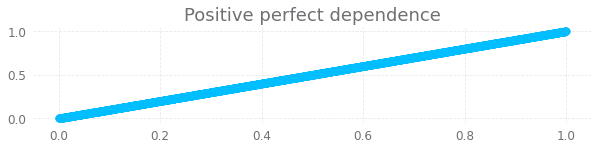

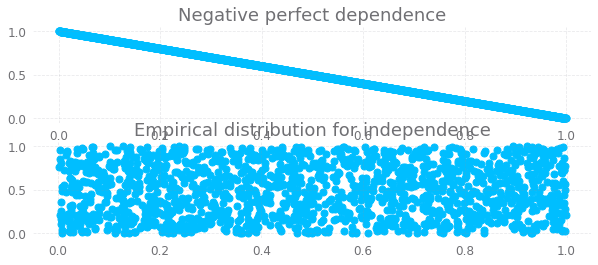

In [194]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.scatter(target[:, 0],
            target[:, 1])
plt.title('Positive perfect dependence')

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.scatter(negative[:, 0],
            negative[:, 1])
plt.title('Negative perfect dependence')

plt.subplot(3, 1, 3)
plt.scatter(forget[:, 0],
            forget[:, 1])
plt.title('Empirical distribution for independence')
plt.show()

In [199]:
def compute_copula_ot_neg_dependence(empirical, target, negative, forget):
    nb_obs = len(target)
    # uniform distribution on samples
    t_measure, n_measure, f_measure, e_measure = (
        np.ones((nb_obs,)) / nb_obs,
        np.ones((nb_obs,)) / nb_obs,
        np.ones((nb_obs,)) / nb_obs,
        np.ones((nb_obs,)) / nb_obs)
    # compute the ground distance matrix between locations
    gdist_e2t = ot.dist(empirical, target)
    gdist_e2n = ot.dist(empirical, negative)
    gdist_e2f = ot.dist(empirical, forget)
    # compute the optimal transport matrix
    e2t_ot = ot.emd(t_measure, e_measure, gdist_e2t)
    e2n_ot = ot.emd(n_measure, e_measure, gdist_e2n)
    e2f_ot = ot.emd(f_measure, e_measure, gdist_e2f)
    # compute the optimal transport distance:
    # <optimal transport matrix, ground distance matrix>_F
    e2t_dist = np.trace(np.dot(np.transpose(e2t_ot), gdist_e2t))
    e2n_dist = np.trace(np.dot(np.transpose(e2n_ot), gdist_e2n))
    e2f_dist = np.trace(np.dot(np.transpose(e2f_ot), gdist_e2f))
    # compute the copula ot dependence measure
    #return 1 - e2t_dist / (e2f_dist + e2t_dist)
    return e2f_dist / (e2f_dist + e2t_dist)


def compute_copula_ot_dependence(empirical, target, forget):
    nb_obs = len(target)
    # uniform distribution on samples
    t_measure, f_measure, e_measure = (
        np.ones((nb_obs,)) / nb_obs,
        np.ones((nb_obs,)) / nb_obs,
        np.ones((nb_obs,)) / nb_obs)
    # compute the ground distance matrix between locations
    gdist_e2t = ot.dist(empirical, target)
    gdist_e2f = ot.dist(empirical, forget)
    # compute the optimal transport matrix
    e2t_ot = ot.emd(t_measure, e_measure, gdist_e2t)
    e2f_ot = ot.emd(f_measure, e_measure, gdist_e2f)
    # compute the optimal transport distance:
    # <optimal transport matrix, ground distance matrix>_F
    e2t_dist = np.trace(np.dot(np.transpose(e2t_ot), gdist_e2t))
    e2f_dist = np.trace(np.dot(np.transpose(e2f_ot), gdist_e2f))
    # compute the copula ot dependence measure
    #return 1 - e2t_dist / (e2f_dist + e2t_dist)
    return e2f_dist / (e2f_dist + e2t_dist)

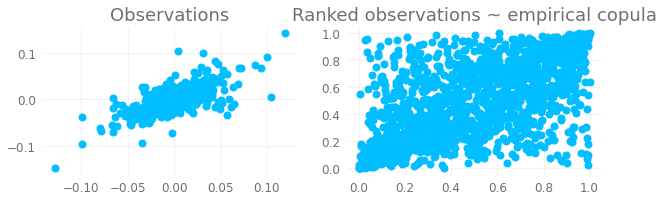

In [196]:
X = tech_returns['aapl']
Y = tech_returns['msft']
Xunif = rankdata(X) / len(X)
Yunif = rankdata(Y) / len(Y)
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.scatter(X, Y)
plt.title('Observations')
plt.subplot(2, 2, 2)
plt.scatter(Xunif, Yunif)
plt.title('Ranked observations ~ empirical copula')
plt.show()

In [201]:
empirical = np.array(
        [[x, y] for x, y in zip(Xunif, Yunif)])
compute_copula_ot_dependence(empirical, target, forget)

0.35145446914580625

## Application to Basket of Stocks

In [149]:
top50 = 'AAPL, MSFT, AMZN, FB, GOOGL, GOOG, TSLA, JPM, JNJ, NVDA, V, PYPL, DIS, PG, UNH, HD, MA, BAC, INTC, NFLX, CMCSA, VZ, ADBE, CRM, ABT, XOM, T, WMT, TMO, CSCO, AVGO, PFE, KO, MRK, ABBV, PEP, CVX, NKE, ACN, LLY, TXN, QCOM, MDT, MCD, NEE, COST, DHR, WFC, UNP'
prices = bt.get(top50, start='2020-01-01')
returns = prices.pct_change(1).dropna()

In [171]:
N = len(returns)
targetN = np.array([[i / N, i / N]
                   for i in range(N)])
forgetN = np.array([[u, v]
                   for u, v in zip(np.random.uniform(size=N),
                                   np.random.uniform(size=N))])

In [384]:
dependencies = np.zeros((len(returns.columns),len(returns.columns)))
for i in range(len(returns.columns)):
    for j in range(len(returns.columns)):
        XN = returns[returns.columns[i]]
        YN = returns[returns.columns[j]]
        XunifN = rankdata(XN) / len(XN)
        YunifN = rankdata(YN) / len(YN)
        empiricalN = np.array(
        [[x, y] for x, y in zip(XunifN, YunifN)])
        dependencies[i, j] = compute_copula_ot_dependence(empiricalN, targetN, forgetN)

distances = 1 - dependencies
distances = distances - distances[0][0]

In [375]:
# distances not a metric, convert a la correlation
distances_metric = np.sqrt(2) * np.sqrt(distances)
distances_metric

array([[0.00000000e+00, 8.39179053e-01, 9.58655304e-01, ...,
        1.13930268e+00, 1.32656896e+00, 1.25350451e+00],
       [8.38383709e-01, 0.00000000e+00, 8.82218942e-01, ...,
        1.12441448e+00, 1.32389684e+00, 1.26150267e+00],
       [9.50335374e-01, 8.79882914e-01, 0.00000000e+00, ...,
        1.24872874e+00, 1.34780221e+00, 1.32854087e+00],
       ...,
       [1.14324766e+00, 1.12731002e+00, 1.24990507e+00, ...,
        0.00000000e+00, 1.34090605e+00, 1.23831278e+00],
       [1.32694922e+00, 1.31644069e+00, 1.35269406e+00, ...,
        1.32328792e+00, 7.89927624e-04, 1.11929834e+00],
       [1.25287850e+00, 1.25866011e+00, 1.33205975e+00, ...,
        1.23661405e+00, 1.12490050e+00, 0.00000000e+00]])

## Alternate Approach -- Copula-free

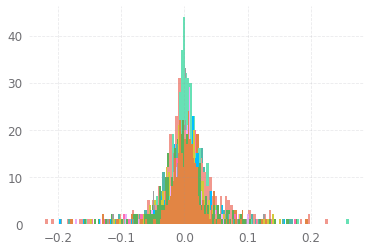

In [291]:
histograms = {}
nb_bins = 100
for name in returns.columns:
    histograms[name] = plt.hist(
        returns[name].values, bins=nb_bins)

In [292]:
n = len(returns.columns)
dist_mat = np.zeros((n, n))

for i, name1 in enumerate(returns.columns):
    hist1 = histograms[name1]
    mid_bins1 = 0.5 * (hist1[1][:-1] + hist1[1][1:])
    for j, name2 in enumerate(returns.columns):
        if j > i:  
            hist2 = histograms[name2]
            mid_bins2 = 0.5 * (hist2[1][:-1] + hist2[1][1:])         
                        
            M = ot.dist(mid_bins1.reshape((nb_bins, 1)),
                        mid_bins2.reshape((nb_bins, 1)))
            M /= M.max()
            
            G0 = ot.emd(hist1[0] / hist1[0].sum(),
                        hist2[0] / hist2[0].sum(),
                        M)

            # compute the optimal transport distance:
            # <optimal transport matrix, ground distance matrix>_F
            ot_dist = np.trace(np.dot(np.transpose(G0), M))
            
            dist_mat[i, j] = ot_dist
            dist_mat[j, i] = ot_dist

In [293]:
dist_mat

array([[0.        , 0.00024451, 0.00096898, ..., 0.00119218, 0.00118729,
        0.00048592],
       [0.00024451, 0.        , 0.00073703, ..., 0.00057888, 0.00158753,
        0.00022578],
       [0.00096898, 0.00073703, 0.        , ..., 0.0005852 , 0.0036306 ,
        0.00100289],
       ...,
       [0.00119218, 0.00057888, 0.0005852 , ..., 0.        , 0.004097  ,
        0.00060125],
       [0.00118729, 0.00158753, 0.0036306 , ..., 0.004097  , 0.        ,
        0.0020001 ],
       [0.00048592, 0.00022578, 0.00100289, ..., 0.00060125, 0.0020001 ,
        0.        ]])

In [400]:
corr_dist = np.sqrt(2) * np.sqrt(1-np.corrcoef(returns.T))

In [410]:
dtw_dist = np.zeros((len(returns.columns),len(returns.columns)))
for i in range(len(returns.columns)):
    for j in range(len(returns.columns)):
        dtw_dist[i, j] = dtw(returns[returns.columns[i]],
                             returns[returns.columns[j]])
dtw_dist

array([[0.        , 0.21737337, 0.28732423, ..., 0.28497947, 0.39018546,
        0.30978707],
       [0.21737337, 0.        , 0.25563313, ..., 0.26303714, 0.37142959,
        0.28569504],
       [0.28732423, 0.25563313, 0.        , ..., 0.27229423, 0.41633131,
        0.31069254],
       ...,
       [0.28497947, 0.26303714, 0.27229423, ..., 0.        , 0.40254359,
        0.27342577],
       [0.39018546, 0.37142959, 0.41633131, ..., 0.40254359, 0.        ,
        0.36240163],
       [0.30978707, 0.28569504, 0.31069254, ..., 0.27342577, 0.36240163,
        0.        ]])

### Efficient Frontier

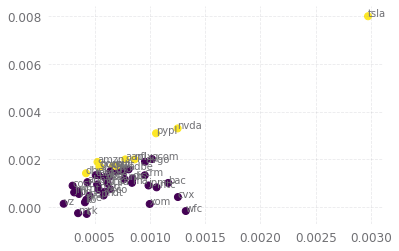

In [371]:
mean = np.mean(returns, axis=0)
#mean = np.mean(np.log(returns, axis=0), axis=0) * 252
variance = np.var(returns, axis=0)
sharpes = mean/np.sqrt(variance) * np.sqrt(252)
fig, ax = plt.subplots()
ax.scatter(variance, mean, c = color)
eff = np.asarray([np.asarray([i, j]) for i, j in zip(variance, mean)])

for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (eff[i, 0], eff[i, 1]))

### Comparison: PCA

#### Dependency Matrix
Note: This is not a metric.

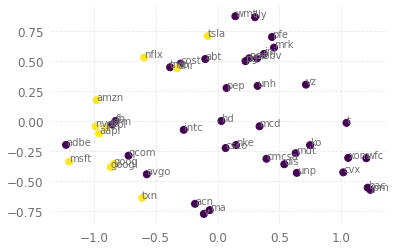

In [382]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

#### "Distances" based on dependency matrix


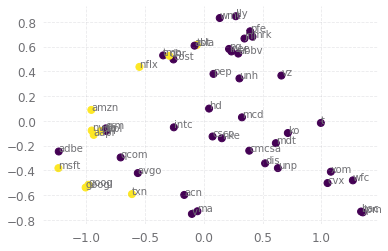

In [383]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(distances_metric)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

#### 1-Wasserstein Distances

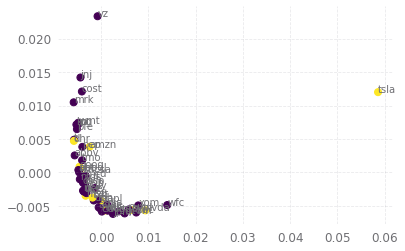

In [362]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(dist_mat)
color = sharpes > 1
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

#### DTW Metric

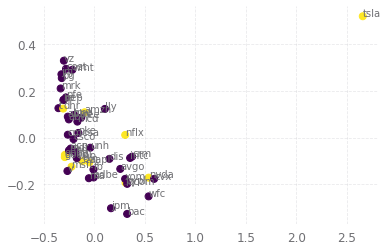

In [411]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(dtw_dist)
color = sharpes > 1
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

#### Correlations

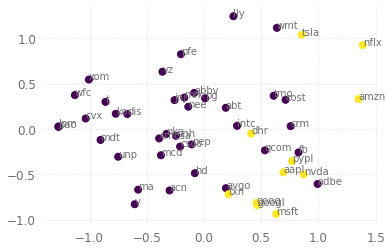

In [414]:
#pca = sklearn.decomposition.PCA(n_components=2).fit_transform(1-np.corrcoef(returns.T))
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(corr_dist)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

#### Transposed Returns

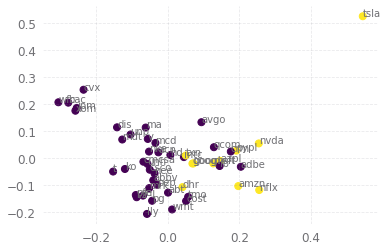

In [413]:
#pca = sklearn.decomposition.PCA(n_components=2).fit_transform(1-np.corrcoef(returns.T))
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(returns.T)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

### Comparison: t-SNE

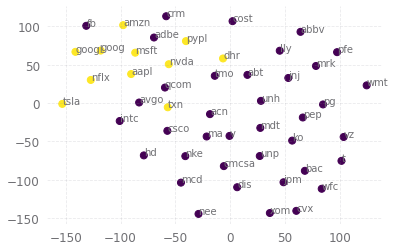

In [368]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

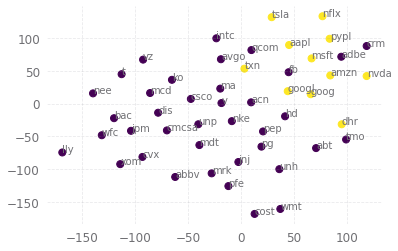

In [385]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(distances_metric)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

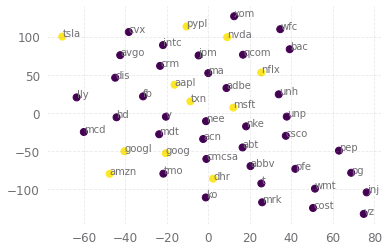

In [369]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(dist_mat)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

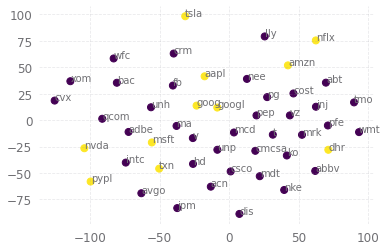

In [415]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(dtw_dist)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

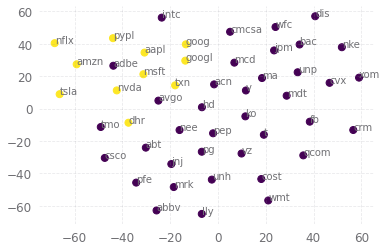

In [402]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(corr_dist)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

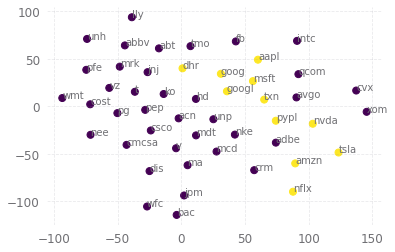

In [417]:
tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(returns.T)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

### Comparison: Clustering

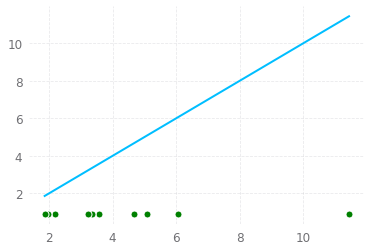

[['fb', 'googl', 'goog'], ['jpm', 'bac', 'vz', 't', 'wfc', 'unp'], ['v', 'dis', 'hd', 'ma', 'csco', 'nke', 'acn', 'mdt'], ['xom', 'cvx'], ['intc', 'avgo', 'txn', 'qcom'], ['aapl', 'msft', 'amzn', 'tsla', 'nvda', 'pypl', 'nflx', 'adbe', 'crm'], ['abt', 'tmo', 'dhr'], ['pg', 'cmcsa', 'ko', 'pep', 'mcd', 'nee'], ['wmt', 'cost'], ['jnj', 'unh', 'pfe', 'mrk', 'abbv', 'lly']]


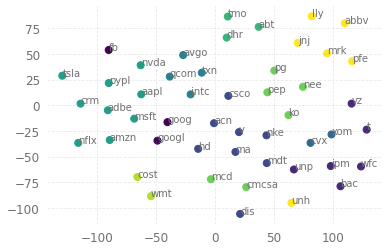

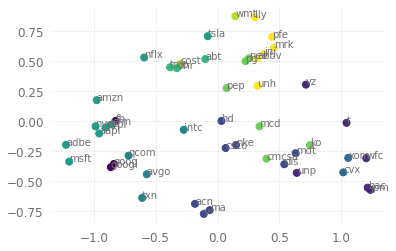

In [431]:
def pred2names(y_pred, names):
    clusters = []
    for i in range(max(y_pred) + 1):
        cluster = []
        for j in range(len(names)):
            if y_pred[j] == i:
                cluster.append(names[j])
        clusters.append(cluster)
    return clusters

t = Tomato(density_type='logDTM', metric='precomputed', k=2)
t.fit(distances)
t.plot_diagram()
print(pred2names(t.labels_, returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))
    
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

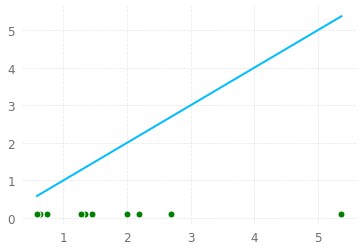

[['fb', 'googl', 'goog'], ['jpm', 'bac', 'vz', 't', 'wfc', 'unp'], ['v', 'dis', 'hd', 'ma', 'csco', 'nke', 'acn', 'mdt'], ['xom', 'cvx'], ['intc', 'avgo', 'txn', 'qcom'], ['aapl', 'msft', 'amzn', 'tsla', 'nvda', 'pypl', 'nflx', 'adbe', 'crm'], ['abt', 'tmo', 'dhr'], ['pg', 'cmcsa', 'ko', 'pep', 'mcd', 'nee'], ['wmt', 'cost'], ['jnj', 'unh', 'pfe', 'mrk', 'abbv', 'lly']]


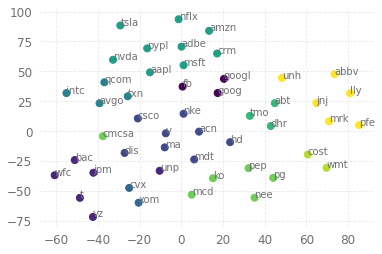

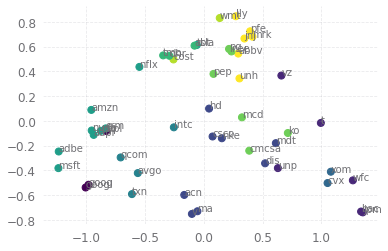

In [432]:
t = Tomato(density_type='logDTM', metric='precomputed', k=2)
t.fit(distances_metric)
t.plot_diagram()
print(pred2names(t.labels_, returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(distances_metric)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))
    
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(distances_metric)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

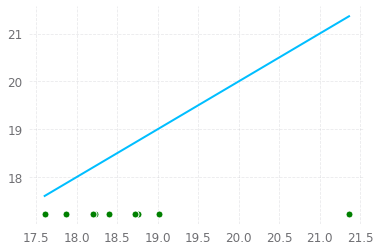

[['googl', 'goog'], ['aapl', 'msft', 'fb', 'v', 'unh', 'hd', 'csco', 'lly', 'txn', 'mcd', 'nee'], ['tsla', 'jpm', 'nvda', 'pypl', 'dis', 'ma', 'bac', 'nflx', 'adbe', 'crm', 'xom', 'qcom', 'wfc'], ['nke', 'unp'], ['intc', 'avgo', 'cvx'], ['abbv', 'dhr'], ['amzn', 'cmcsa', 'abt', 'tmo', 'acn', 'mdt'], ['t', 'pfe', 'ko', 'mrk'], ['jnj', 'pg', 'vz', 'wmt', 'pep', 'cost']]


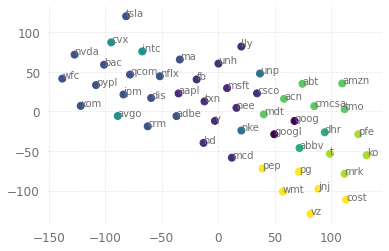

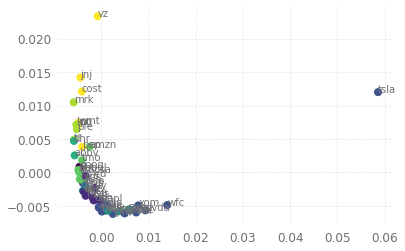

In [433]:
t = Tomato(density_type='logDTM', metric='precomputed', k=2)
t.fit(dist_mat)
t.plot_diagram()
print(pred2names(t.labels_, returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(dist_mat)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))
    
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(dist_mat)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

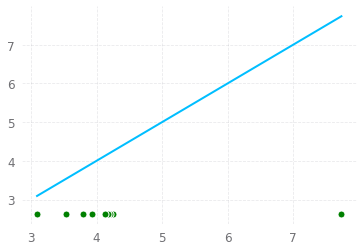

[['fb', 'googl', 'goog'], ['amzn', 'nflx', 'vz', 'wmt', 'lly', 'cost'], ['jnj', 'pg', 'abt', 'pfe', 'mrk', 'abbv', 'pep', 'nee'], ['v', 'dis', 'unh', 'hd', 'ma', 'nke', 'mdt', 'mcd', 'unp'], ['jpm', 'bac', 'wfc'], ['cmcsa', 't', 'ko'], ['tmo', 'dhr'], ['aapl', 'msft', 'tsla', 'nvda', 'pypl', 'intc', 'adbe', 'crm', 'avgo', 'txn', 'qcom'], ['csco', 'acn'], ['xom', 'cvx']]


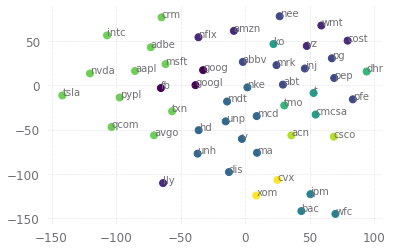

In [418]:
t = Tomato(density_type='logDTM', metric='precomputed', k=2)
t.fit(dtw_dist)
t.plot_diagram()
print(pred2names(t.labels_, returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(dtw_dist)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

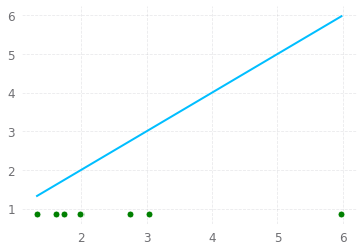

[['fb', 'googl', 'goog'], ['jpm', 'bac', 'vz', 't', 'wfc'], ['v', 'dis', 'unh', 'ma', 'csco', 'nke', 'acn', 'mdt', 'mcd'], ['aapl', 'msft', 'amzn', 'tsla', 'nvda', 'pypl', 'nflx', 'adbe', 'crm'], ['xom', 'cvx', 'unp'], ['jnj', 'pg', 'hd', 'cmcsa', 'abt', 'pfe', 'ko', 'mrk', 'abbv', 'pep', 'lly', 'nee'], ['intc', 'avgo', 'txn', 'qcom'], ['tmo', 'dhr'], ['wmt', 'cost']]


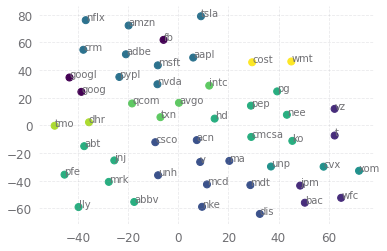

In [427]:
t = Tomato(density_type='logDTM', metric='precomputed', k=2)
t.fit(corr_dist)
t.plot_diagram()
print(pred2names(t.labels_, returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(corr_dist)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = t.labels_)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

[['aapl', 'msft', 'amzn', 'fb', 'googl', 'goog', 'tsla', 'nvda', 'pypl', 'intc', 'nflx', 'adbe', 'crm', 'csco', 'avgo', 'acn', 'txn', 'qcom'], ['jpm', 'bac', 'xom', 'cvx', 'wfc'], ['jnj', 'pg', 'unh', 'hd', 'cmcsa', 'vz', 'abt', 't', 'wmt', 'tmo', 'pfe', 'ko', 'mrk', 'abbv', 'pep', 'lly', 'mcd', 'nee', 'cost', 'dhr'], ['v', 'dis', 'ma', 'nke', 'mdt', 'unp']]


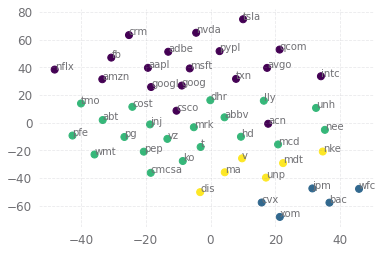

In [429]:
y_pred = tomato(returns.T, k=2, n_clusters=8)
pred2names(y_pred[0], returns.columns)
print(pred2names(y_pred[0], returns.columns))

tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(returns.T)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = np.array(y_pred[0])+1)
for i, txt in enumerate(returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

In [406]:
dbscan_pred = sklearn.cluster.DBSCAN(eps=1, min_samples=2).fit(distances)
dbscan_pred.labels_+1
pred2names(dbscan_pred.labels_+1, returns.columns)


[['tsla', 'unh'],
 ['aapl',
  'msft',
  'amzn',
  'fb',
  'googl',
  'goog',
  'nvda',
  'pypl',
  'intc',
  'nflx',
  'adbe',
  'crm',
  'avgo',
  'txn',
  'qcom'],
 ['jpm', 'bac', 'vz', 'xom', 't', 'cvx', 'wfc'],
 ['jnj', 'pfe', 'mrk'],
 ['v',
  'dis',
  'hd',
  'ma',
  'cmcsa',
  'csco',
  'ko',
  'nke',
  'acn',
  'mdt',
  'mcd',
  'unp'],
 ['pg', 'pep', 'nee'],
 ['abt', 'tmo', 'dhr'],
 ['wmt', 'cost'],
 ['abbv', 'lly']]

In [393]:
dbscan_pred = sklearn.cluster.DBSCAN(eps=1.6, min_samples=2).fit(distances_metric)
dbscan_pred.labels_+1
pred2names(dbscan_pred.labels_+1, returns.columns)

[['tsla', 'unh', 'abbv', 'nke', 'lly', 'nee'],
 ['aapl',
  'msft',
  'amzn',
  'fb',
  'googl',
  'goog',
  'nvda',
  'v',
  'pypl',
  'dis',
  'pg',
  'hd',
  'ma',
  'intc',
  'nflx',
  'cmcsa',
  'adbe',
  'crm',
  'csco',
  'avgo',
  'ko',
  'pep',
  'acn',
  'txn',
  'qcom',
  'mdt',
  'mcd',
  'unp'],
 ['jpm', 'bac', 'vz', 'xom', 't', 'cvx', 'wfc'],
 ['jnj', 'pfe', 'mrk'],
 ['abt', 'tmo', 'dhr'],
 ['wmt', 'cost']]

In [306]:
dbscan_pred = sklearn.cluster.DBSCAN(eps=0.009, min_samples=2).fit(dist_mat)
dbscan_pred.labels_+1
pred2names(dbscan_pred.labels_+1, returns.columns)

[['tsla', 'vz'],
 ['aapl',
  'msft',
  'amzn',
  'fb',
  'googl',
  'goog',
  'jpm',
  'jnj',
  'nvda',
  'v',
  'pypl',
  'dis',
  'pg',
  'unh',
  'hd',
  'ma',
  'bac',
  'intc',
  'nflx',
  'cmcsa',
  'adbe',
  'crm',
  'abt',
  'xom',
  't',
  'wmt',
  'tmo',
  'csco',
  'avgo',
  'pfe',
  'ko',
  'mrk',
  'abbv',
  'pep',
  'cvx',
  'nke',
  'acn',
  'lly',
  'txn',
  'qcom',
  'mdt',
  'mcd',
  'nee',
  'cost',
  'dhr',
  'wfc',
  'unp']]

In [290]:
dbscan_pred = sklearn.cluster.DBSCAN(eps=0.8, min_samples=2).fit(corr_dist)
dbscan_pred.labels_+1
pred2names(dbscan_pred.labels_+1, returns.columns)

[['amzn', 'tsla', 'nflx', 'wmt', 'lly'],
 ['aapl',
  'msft',
  'fb',
  'googl',
  'goog',
  'jpm',
  'jnj',
  'nvda',
  'v',
  'pypl',
  'dis',
  'pg',
  'unh',
  'hd',
  'ma',
  'bac',
  'intc',
  'cmcsa',
  'vz',
  'adbe',
  'crm',
  'abt',
  'xom',
  't',
  'tmo',
  'csco',
  'avgo',
  'pfe',
  'ko',
  'mrk',
  'abbv',
  'pep',
  'cvx',
  'nke',
  'acn',
  'txn',
  'qcom',
  'mdt',
  'mcd',
  'nee',
  'cost',
  'dhr',
  'wfc',
  'unp']]